In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
plt.switch_backend('agg')
%matplotlib inline
import numpy as np
import pandas as pd
#import seaborn as sns
#import coremltools

#from scipy import stats
from IPython.display import display, HTML

#from sklearn import metrics
#from sklearn.metrics import classification_report

#from sklearn import preprocessing
#from sklearn.preprocessing import OneHotEncoder


#import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"] = "GPU-47a85f0a-67f6-b4ec-c7ce-3cb01dc30fc4, GPU-a19ae4ae-43c6-c5bb-4b7a-d053b52e5c92"
#os.environ['MKL_NUM_THREADS'] = '24'
#os.environ['GOTO_NUM_THREADS'] = '24'
#os.environ['OMP_NUM_THREADS'] = '24'
#os.environ['openmp'] = 'True'

#os.environ['KERAS_BACKEND'] = 'tensorflow'

#import keras
#import keras.backend as K
#from keras.models import Sequential, Model
#from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D,Input, LSTM, RepeatVector, Multiply, Lambda, Bidirectional, Permute
#from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, UpSampling1D, AveragePooling1D, TimeDistributed
#from keras.utils import np_utils
#from keras.layers import Activation
#from keras.regularizers import l2

import tensorflow as tf
#tf.enable_eager_execution()

#device_type = 'GPU'
#n_gpus = 2
#devices = tf.config.experimental.list_physical_devices(
#          device_type)
#devices_names = [d.name.split('e:')[1] for d in devices]
#strategy = tf.distribute.MirroredStrategy(
#           devices=devices_names[:n_gpus])


import numpy as np
import pandas as pd
from SampleFileTools1 import SampleFile



#from attention_decoder import AttentionDecoder
#from attention_new import attention

#from Fractal_Tanimoto import ftnmt_loss


#from scipy import signal
import random as ran


In [2]:
def glitch(gauss_amp):
    sigma = ran.uniform(0.2,2)
    amp = ran.uniform(-gauss_amp,gauss_amp)
    gauss=(signal.gaussian(512, std=sigma)*amp)
    
    #find the start and end indicies of the gaussian curve
    trigger=0
    for ex,y in enumerate(gauss,start=0):
        if y != 0 and trigger==0:
            trigger=1
            start=ex-1
        if trigger==1 and y==0:
            stop=ex
            break
            
    # find the range of the gaussian curve		
    ragnar = stop-start
    # create the glitch array
    glitch = np.ones(512)-1
    # randomise injection point
    begin=ran.randint(0,512-ragnar)
    # make the glitch
    glitch[begin:begin+ragnar]=gauss[start:stop]
    
    return glitch


In [3]:
#obj = SampleFile()
#obj.read_hdf("BBH_sample_files/default_training_1_sec_10to80_1.hdf")
#df = obj.as_dataframe(True,True,True,False) #creating the dataframe from the hdf file.

obj_test = SampleFile()
obj_test.read_hdf("BBH_sample_files/default_diff.hdf")
df_test = obj_test.as_dataframe(True,True,True,False) #creating the dataframe from the hdf file.

df_test = df_test[0:5000]


Alistair's files


In [163]:
import h5py

f1 = h5py.File('/fred/oz016/denoising/q/100k_q_snr_10-30_4.hdf', 'r')
list(f1.keys())


['injection_parameters', 'signals', 'simulation_ranges']

In [164]:
f1['signals'].keys()


<KeysViewHDF5 ['H1 pure strain', 'H1 strain', 'H1 times', 'L1 pure strain', 'L1 strain', 'L1 times', 'V1 pure strain', 'V1 strain', 'V1 times']>

In [165]:
import h5py

strains_d = dict()
signals_d = dict()
f1 = h5py.File('/fred/oz016/denoising/q/100k_q_snr_10-30_4.hdf', 'r')
list(f1.keys())
strains = []
signals = []
for det in ['H1','L1','V1']:
    strains_d[det] = f1['signals']['{0} strain'.format(det)][()]
    signals_d[det] = f1['signals']['{0} pure strain'.format(det)][()]
strains.append(strains_d)
signals.append(signals_d)

strains = {
        'H1':np.concatenate([x['H1'] for x in strains]),
        'L1':np.concatenate([x['L1'] for x in strains]),
        'V1':np.concatenate([x['V1'] for x in strains])
    }

signals = {
        'H1':np.concatenate([x['H1'] for x in signals]),
        'L1':np.concatenate([x['L1'] for x in signals]),
        'V1':np.concatenate([x['V1'] for x in signals])
    }


In [166]:
f1.close()


In [167]:
def normalize_test_new(a):
    new_array = []
    for i in range(100000):
        dataset = a[i]
#        dataset = dataset[1536:2048]
        maximum = np.max(dataset)
        minimum = np.abs(np.min(dataset))
        for j in range(512):
            if(dataset[j] > 0):
                dataset[j] = dataset[j]/maximum
            else:
                dataset[j] = dataset[j]/minimum
#        dataset = dataset+gauss
        new_array.append(dataset)
    return new_array

h1_test_new = normalize_test_new(strains['L1'])

#h1_pure_new = normalize_new(h1_pure_new)
h1_test_pure_new = normalize_test_new(signals['L1'])


Alistair's file end

In [4]:
# Same labels will be reused throughout the program
#LABELS = ['1',
#          '2',
#          '3',
#          '4',
#          '5',
#          '6',
#          '7',
#          '8']
# The number of steps within one time segment
#TIME_PERIODS = 512
TIME_PERIODS = 512
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
#STEP_DISTANCE = 512
STEP_DISTANCE = 512

#Extracting seconds_before_event from 'info.csv' file

#dataset = pd.read_csv('info.csv')
#sbe = dataset.iloc[:,1].values


#Creating Timestamp column
timestamp = []
event_time = 1234567936
count = 0
grid = []
grid_test = []
for i in range(50000):
#    grid.append(np.linspace(event_time - sbe[i], event_time + (2.0 - sbe[i]), int(2048 * 0.4)))
    grid.append(np.linspace(event_time - 0.20, event_time + 0.05, 512))
for i in range(8):
#    grid.append(np.linspace(event_time - sbe[i], event_time + (2.0 - sbe[i]), int(2048 * 0.4)))
    grid_test.append(np.linspace(event_time - 0.20, event_time + 0.05, 512))
    
timestamp = np.hstack(grid)#timestamp is now the array representing the required Timestamp column of the datastructure
timestamp_test = np.hstack(grid_test)

def normalize_noisy(a):
    new_array = []
    for i in range(50000):
        dataset = a[i]
        dataset = dataset/10
        new_array.append(dataset)
    return new_array

def normalize_pure(a):
    new_array = []
    for i in range(50000):
        dataset = a[i]
        dataset = dataset/1e-22
        new_array.append(dataset)
    return new_array

def normalize_test_noisy(a):
    new_array = []
    for i in range(5000):
        dataset = a[i]
        dataset = dataset/10
        new_array.append(dataset)
    return new_array

def normalize_test_pure(a):
    new_array = []
    for i in range(5000):
        dataset = a[i]
        dataset = dataset/1e-22
        new_array.append(dataset)
    return new_array

def normalize_new(a):
    new_array = []
    for i in range(50000):
        dataset = a[i]
        dataset = dataset[1536:2048]
        maximum = np.max(dataset)
        minimum = np.abs(np.min(dataset))
        for j in range(512):
            if(dataset[j] > 0):
                dataset[j] = dataset[j]/maximum
            else:
                dataset[j] = dataset[j]/minimum
#        dataset = dataset+gauss
        new_array.append(dataset)
    return new_array

def normalize_glitch_new(a):
    new_array = []
    for i in range(50000):
        dataset = a[i]
        dataset = dataset[1536:2048]
        maximum = np.max(dataset)
        minimum = np.abs(np.min(dataset))
        for j in range(512):
            if(dataset[j] > 0):
                dataset[j] = dataset[j]/maximum
            else:
                dataset[j] = dataset[j]/minimum
#        dataset = dataset + glitch(10)
        new_array.append(dataset)
    return new_array
        
def normalize_test_glitch_new(a):
    new_array = []
    for i in range(5000):
        dataset = a[i]
#        dataset = dataset[1536:2048]
        maximum = np.max(dataset)
        minimum = np.abs(np.min(dataset))
        for j in range(512):
            if(dataset[j] > 0):
                dataset[j] = dataset[j]/maximum
            else:
                dataset[j] = dataset[j]/minimum
#        dataset = dataset+ glitch(10)
        new_array.append(dataset)
    return new_array

def normalize_test_new(a):
    new_array = []
    for i in range(5000):
        dataset = a[i]
#        dataset = dataset[1536:2048]
        maximum = np.max(dataset)
        minimum = np.abs(np.min(dataset))
        for j in range(512):
            if(dataset[j] > 0):
                dataset[j] = dataset[j]/maximum
            else:
                dataset[j] = dataset[j]/minimum
#        dataset = dataset+gauss
        new_array.append(dataset)
    return new_array


In [25]:
#new = df[['h1_signal', 'l1_signal', 'v1_signal']].copy() # Extracting h1_signal, l1_signal and v1_signal columns
                                                         # from hdf file.    
#new = df[['l1_strain']].copy() 
new_test = df_test[['v1_strain']].copy()

#new_pure = df[['l1_signal']].copy() 
new_test_pure = df_test[['v1_signal']].copy()

#h1 = new.iloc[:,0] #Extracting h1_signal from 'new' dataframe
#l1 = new.iloc[:,1] #Extracting l1_signal from 'new' dataframe

#v1 = new.iloc[:,2] #Extracting v1_signal from 'new' dataframe
h1_test = new_test.iloc[:,0]

#h1_pure = new_pure.iloc[:,0] #Extracting h1_signal from 'new' dataframe
#l1 = new.iloc[:,1] #Extracting l1_signal from 'new' dataframe
#v1 = new.iloc[:,2] #Extracting v1_signal from 'new' dataframe
h1_test_pure = new_test_pure.iloc[:,0]

#h1_test = []
#h1_test_pure = []
#for i in range(4000):
#    a = df_test['mass1']
#    b = df_test['mass2']
#    if(a[i] >= 1.7 and a[i] <= 4.0 and b[i] >= 1.7 and b[i] <= 4.0):
#        h1_test.append(df_test['v1_strain'][i])
#        h1_test_pure.append(df_test['v1_signal'][i])
        
#h1_new = normalize_noisy(h1)
h1_test_new = normalize_test_noisy(h1_test)

#h1_pure_new = normalize_pure(h1_pure)
h1_test_pure_new = normalize_test_pure(h1_test_pure)

# For no glitch

#h1_glitch_new = h1_new
#h1_test_glitch_new = h1_test_new

# Only for plotting and comparing
#h1_test_glitch_pure_new = h1_test_pure_new


#Uncomment this for glitch:

#h1_new = normalize_new(h1_new)
h1_test_new = normalize_test_new(h1_test_new)

#h1_pure_new = normalize_new(h1_pure_new)
h1_test_pure_new = normalize_test_new(h1_test_pure_new)

# Only for plotting and comparing. Uncomment this for glitch
#h1_test_glitch_pure_new = normalize_test_glitch_new(h1_test_pure_new)


In [168]:
from numpy import array
# split a univariate sequence into samples
def split_sequence(sequence_noisy,sequence_pure,n_steps):
    X, y = list(), list()
    for i in range(len(sequence_noisy)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence_noisy)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence_noisy[i:end_ix], sequence_pure[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


# choose a number of time steps
n_steps = 4
X_test_noisy = []
X_test_pure = []

for i in range(100000):
    X_noisy = h1_test_new[i]
    X_pure = h1_test_pure_new[i]
    X_noisy = np.pad(X_noisy, (4, 4), 'constant', constant_values=(0, 0))
    X_pure = np.pad(X_pure, (4, 4), 'constant', constant_values=(0, 0))
    # split into samples
    X, y = split_sequence(X_noisy, X_pure, n_steps)
    X_test_noisy.append(X)
    X_test_pure.append(y)
    
X_test_noisy = np.asarray(X_test_noisy)
X_test_pure = np.asarray(X_test_pure)


In [169]:
##### print("\n--- Reshape data to be accepted by Keras ---\n")

# Inspect x data
#print('x_train_noisy shape: ', X_train_noisy.shape)
print('x_test_noisy shape: ', X_test_noisy.shape)
# Displays (20869, 40, 3)
#print(x_train.shape[0], 'training samples')
# Displays 20869 train samples

# Inspect x data
#print('x_train_pure shape: ', X_train_pure.shape)
print('x_test_pure shape: ', X_test_pure.shape)

# Displays (20869, 40, 3)
#print(x_train.shape[0], 'training samples')
# Displays 20869 train samples

# Set input & output dimensions

num_time_periods, num_sensors = 4, 1

num_time_periods_test, num_sensors_test = 4, 1

# Set input_shape / reshape for Keras
# Remark: acceleration data is concatenated in one array in order to feed
# it properly into coreml later, the preferred matrix of shape [40,3]
# cannot be read in with the current version of coreml (see also reshape
# layer as the first layer in the keras model)
input_shape = (num_time_periods*num_sensors)
input_shape_test = (num_time_periods_test*num_sensors_test)

#X_train_noisy = X_train_noisy.reshape(X_train_noisy.shape[0], 516, input_shape)
X_test_noisy = X_test_noisy.reshape(X_test_noisy.shape[0], 516, input_shape)
#X_train_pure = X_train_pure.reshape(X_train_pure.shape[0], 516, 1)
X_test_pure = X_test_pure.reshape(X_test_pure.shape[0], 516, 1)


#print('x_train_noisy shape:', X_train_noisy.shape)

#print('input_shape:', input_shape)


print('x_test_noisy shape:', X_test_noisy.shape)

print('input_shape:', input_shape_test)


#print('x_train_pure shape:', X_train_pure.shape)

#print('input_shape:', input_shape)


print('x_test_pure shape:', X_test_pure.shape)
print('input_shape:', input_shape_test)



# Convert type for Keras otherwise Keras cannot process the data
#X_train_noisy = X_train_noisy.astype("float32")

X_test_noisy = X_test_noisy.astype("float32")

# Convert type for Keras otherwise Keras cannot process the data
#X_train_pure = X_train_pure.astype("float32")

X_test_pure = X_test_pure.astype("float32")


x_test_noisy shape:  (100000, 516, 4)
x_test_pure shape:  (100000, 516)
x_test_noisy shape: (100000, 516, 4)
input_shape: 4
x_test_pure shape: (100000, 516, 1)
input_shape: 4


In [11]:
#from keras import backend as K
def fractal_tanimoto_loss(y_true, y_pred, depth=0, smooth=1e-6):
    x = y_true
    y = y_pred
#    x_norm = K.sum(x)
#    y_norm = K.sum(y)
#    x = x/x_norm
#    y = y/y_norm
    depth = depth+1
    scale = 1./len(range(depth))
    
    def inner_prod(y, x):
        prod = y*x
        prod = tf.math.reduce_sum(prod, axis=1)
        
        return prod
    
    def tnmt_base(x, y):

        tpl  = inner_prod(y,x)
        tpp  = inner_prod(y,y)
        tll  = inner_prod(x,x)


        num = tpl + smooth
        denum = 0.0
        result = 0.0
        for d in range(depth):
            a = 2.**d
            b = -(2.*a-1.)

            denum = denum + tf.math.reciprocal( a*(tpp+tll) + b *tpl + smooth)
#            denum = ( a*(tpp+tll) + b *tpl + smooth)
#            result = tf.math.reduce_mean((result + (num/denum)), axis=0)

        result =  num * denum * scale
#        result = result
        return  result*scale
    
    
    l1 = tnmt_base(x,y)
#        l2 = self.tnmt_base(1.-preds, 1.-labels)

#        result = 0.5*(l1+l2)
    result = l1
    
    return  1. - result


In [10]:
#import tf.keras.backend as K

def correlation_coefficient_loss(y_true, y_pred, smooth=1e-6):
    x = y_true
    y = y_pred
    mx = tf.keras.backend.mean(x)
    my = tf.keras.backend.mean(y)
#    xm, ym = x-mx, y-my
    xm, ym = x, y
    r_num = tf.keras.backend.sum(xm * ym)
    l = tf.keras.backend.sum(tf.keras.backend.square(xm)) 
    r = tf.keras.backend.sum(tf.keras.backend.square(ym))
    r_1 = l + r - r_num
    
    gdc = (r_num + smooth)/(r_1 + smooth)

#flatten label and prediction tensors
#    inputs = y_pred
#    targets = y_true
    
#    intersection = K.sum(K.dot(y_true, y_pred))
#    total = K.sum(y_pred) + K.sum(y_true)
#    union = total - intersection
    
#    IoU = (intersection + smooth) / (union + smooth)
    a = tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true), axis=-1)
#    return a - K.sum(r)
    return 0.80*a - 0.20*gdc


In [12]:
#from keras.models import load_model
 
# load model
model = tf.keras.models.load_model('Models/model_FractalTanimoto_FT_MSE.h5', custom_objects={'fractal_tanimoto_loss': fractal_tanimoto_loss})
# summarize model.
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 516, 4, 1)         0         
_________________________________________________________________
time_distributed (TimeDistri (None, 516, 4, 32)        64        
_________________________________________________________________
time_distributed_1 (TimeDist (None, 516, 4, 32)        0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 516, 2, 32)        0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 516, 2, 16)        528       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 516, 2, 16)        0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 516, 32)           0

In [46]:
#from keras.models import load_model
 
# load model
model = tf.keras.models.load_model('Models/model_FractalTanimoto_MSE.h5')
# summarize model.
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 516, 4, 1)         0         
_________________________________________________________________
time_distributed (TimeDistri (None, 516, 4, 32)        64        
_________________________________________________________________
time_distributed_1 (TimeDist (None, 516, 4, 32)        0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 516, 2, 32)        0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 516, 2, 16)        528       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 516, 2, 16)        0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 516, 32)           0

In [12]:
#from keras.models import load_model
 
# load model
model = tf.keras.models.load_model('Models/model.h5', custom_objects={'correlation_coefficient_loss': correlation_coefficient_loss})
# summarize model.
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 516, 4, 1)         0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 516, 4, 32)        64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 516, 4, 32)        0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 516, 2, 32)        0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 516, 2, 16)        528       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 516, 2, 16)        0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 516, 32)          

In [170]:
decoded_signals = model.predict(X_test_noisy, batch_size=2000)
#decoded_signals = decoded_signals.reshape(-1,512,1)
#decoded_signals = normalize_decoded_new(decoded_signals)

score = model.evaluate(X_test_noisy, X_test_pure, verbose=1, batch_size=2000)

print('\nAccuracy on test data: %0.2f' % score[1])
print('\nLoss on test data: %0.2f' % score[0])


50/50 [==============================] - 16s 316ms/step - loss: 0.0394 - accuracy: 0.0676

Accuracy on test data: 0.07

Loss on test data: 0.04


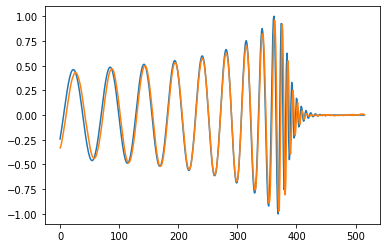

In [175]:
plt.plot(X_test_pure[0])
plt.plot(decoded_signals[0])
#plt.plot(X_test_pure[1])
#plt.savefig('BNS_autoencoder/New_model/Plot_4.png', dpi=400)


In [23]:
#for i in range(4000):
#    np.savetxt('Autoencoder_files/Model/Preds_'+str(i)+'.txt', np.transpose(decoded_signals[i]))
    

In [87]:
#decoded_signals_h1 = []
decoded_signals_h1.append(decoded_signals)


In [176]:
#decoded_signals_l1 = []
decoded_signals_l1.append(decoded_signals)


In [130]:
decoded_signals_v1 = decoded_signals


In [179]:
import h5py

hf = h5py.File('Autoencoder_files/500k_q_snr_10-30_denoised_training_set.hdf', 'w')
hf.create_dataset('H1 denoised', data=decoded_signals_h1)
hf.create_dataset('L1 denoised', data=decoded_signals_l1)
#hf.create_dataset('V1 denoised', data=decoded_signals_v1)


<HDF5 dataset "L1 denoised": shape (5, 100000, 516, 1), type "<f4">

In [180]:
hf.close()
